In [121]:
!pip install GPyOpt catboost

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.cluster import KMeans
import shap
shap.initjs()

In [123]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

In [124]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [125]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


In [126]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [127]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

,count
CustomerID,
True,1454


In [128]:
data[data.Description.isnull()].UnitPrice.value_counts()

,count
UnitPrice,
0.0,1454


In [129]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [130]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


In [131]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,539724
True,731


In [132]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,540455


In [133]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

In [134]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [135]:
data.isnull().sum().sum()

0

In [136]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [137]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


In [138]:
data.InvoiceNo.nunique()

22186

In [139]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

,count
IsCancelled,
False,97.81007
True,2.18993


In [140]:
data.loc[data.IsCancelled==True].describe()

,Quantity,InvoiceDate,UnitPrice
count,8896.000000,8896,8896.000000
mean,-30.882981,2011-06-27 06:10:27.308902912,18.862815
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-22 16:07:00,1.450000
50%,-2.000000,2011-07-11 13:51:00,2.950000
75%,-1.000000,2011-10-06 20:36:00,4.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1170.746458,NaN,444.590459


In [141]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

In [142]:
data.StockCode.nunique()

3663

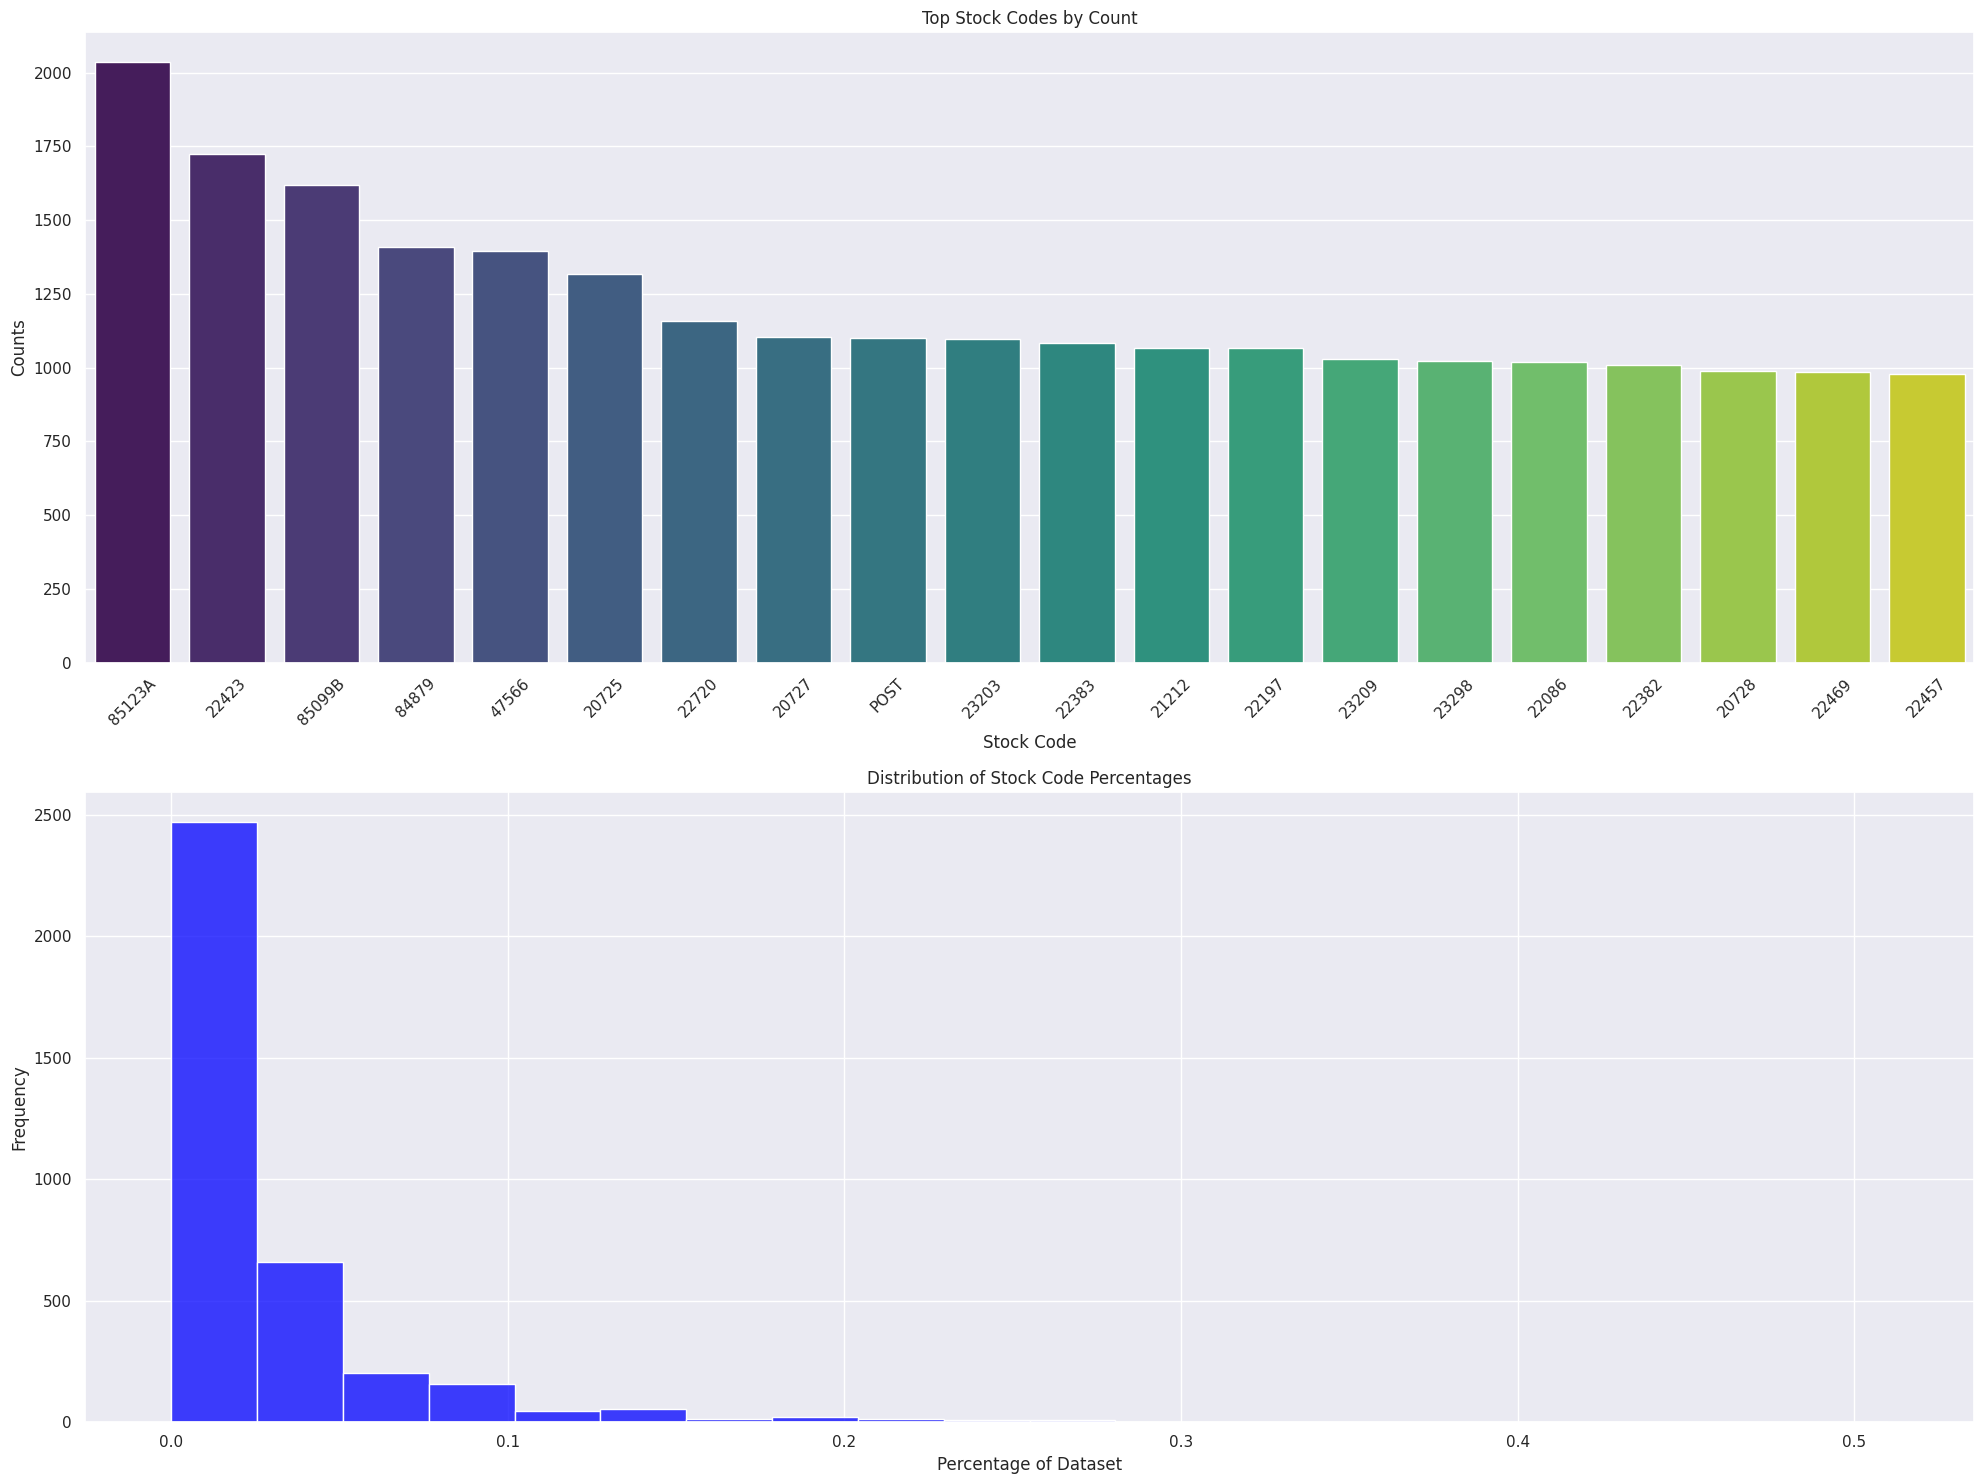

In [143]:
if 'StockCode' not in data.columns or data.empty:
    raise ValueError("The dataset is either empty or does not contain the 'StockCode' column.")

stockcode_counts = data['StockCode'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(20, 15))

top_n = min(20, len(stockcode_counts))

sns.barplot(x=stockcode_counts.iloc[0:top_n].index,
            y=stockcode_counts.iloc[0:top_n].values,
            ax=ax[0], palette="viridis")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stock Code")
ax[0].set_title("Top Stock Codes by Count")
ax[0].tick_params(axis='x', rotation=45)

stockcode_percent = np.round(stockcode_counts / data.shape[0] * 100, 2)

sns.histplot(stockcode_percent, kde=False, bins=20, ax=ax[1], color="blue")
ax[1].set_title("Distribution of Stock Code Percentages")
ax[1].set_xlabel("Percentage of Dataset")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [144]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

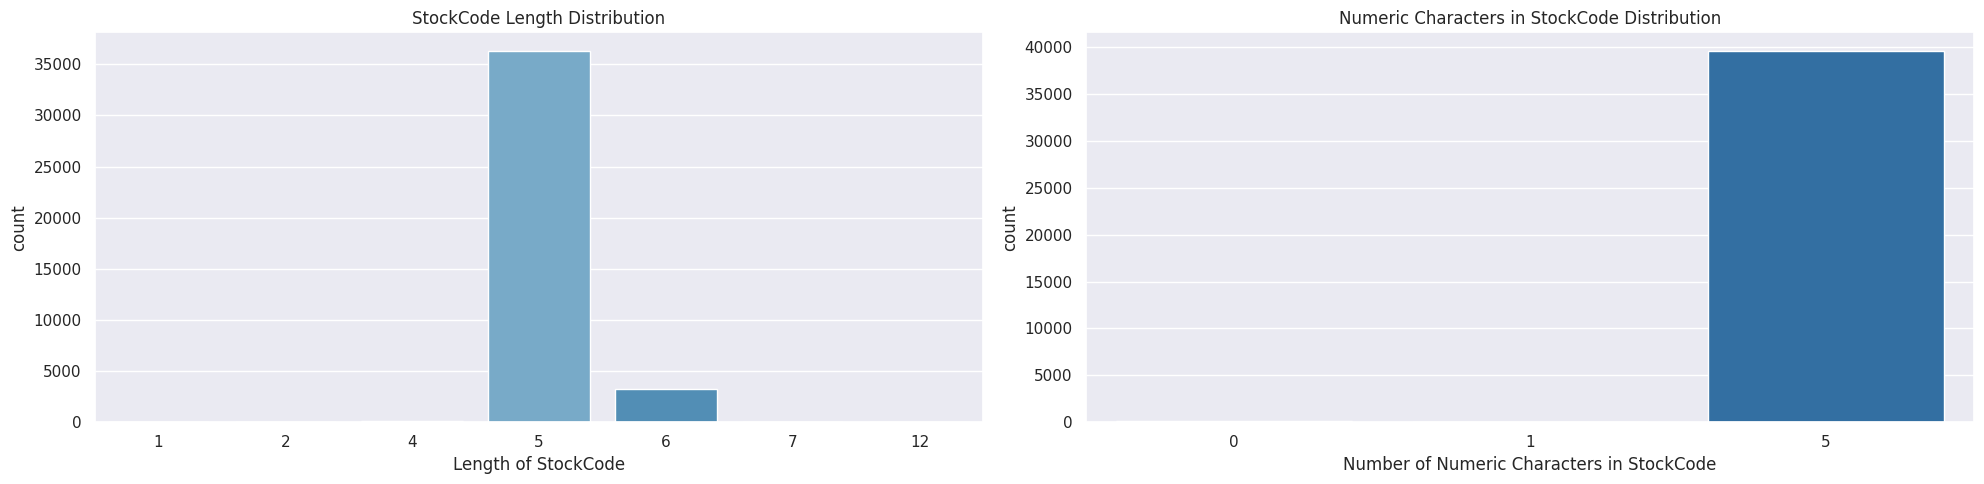

In [147]:
sampled_data = data.sample(frac=0.1, random_state=42)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x="StockCodeLength", data=sampled_data, palette="Blues", ax=ax[0])
sns.countplot(x="nNumericStockCode", data=sampled_data, palette="Blues", ax=ax[1])
ax[0].set_xlabel("Length of StockCode")
ax[0].set_title("StockCode Length Distribution")
ax[1].set_xlabel("Number of Numeric Characters in StockCode")
ax[1].set_title("Numeric Characters in StockCode Distribution")
plt.tight_layout()
plt.show()


In [148]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

,count
lowercase_descriptions,
postage,1099
manual,290
carriage,133
dotcom postage,16
bank charges,12
pads to match all cushions,4


In [149]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [150]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

In [151]:
data.Description.nunique()

2983

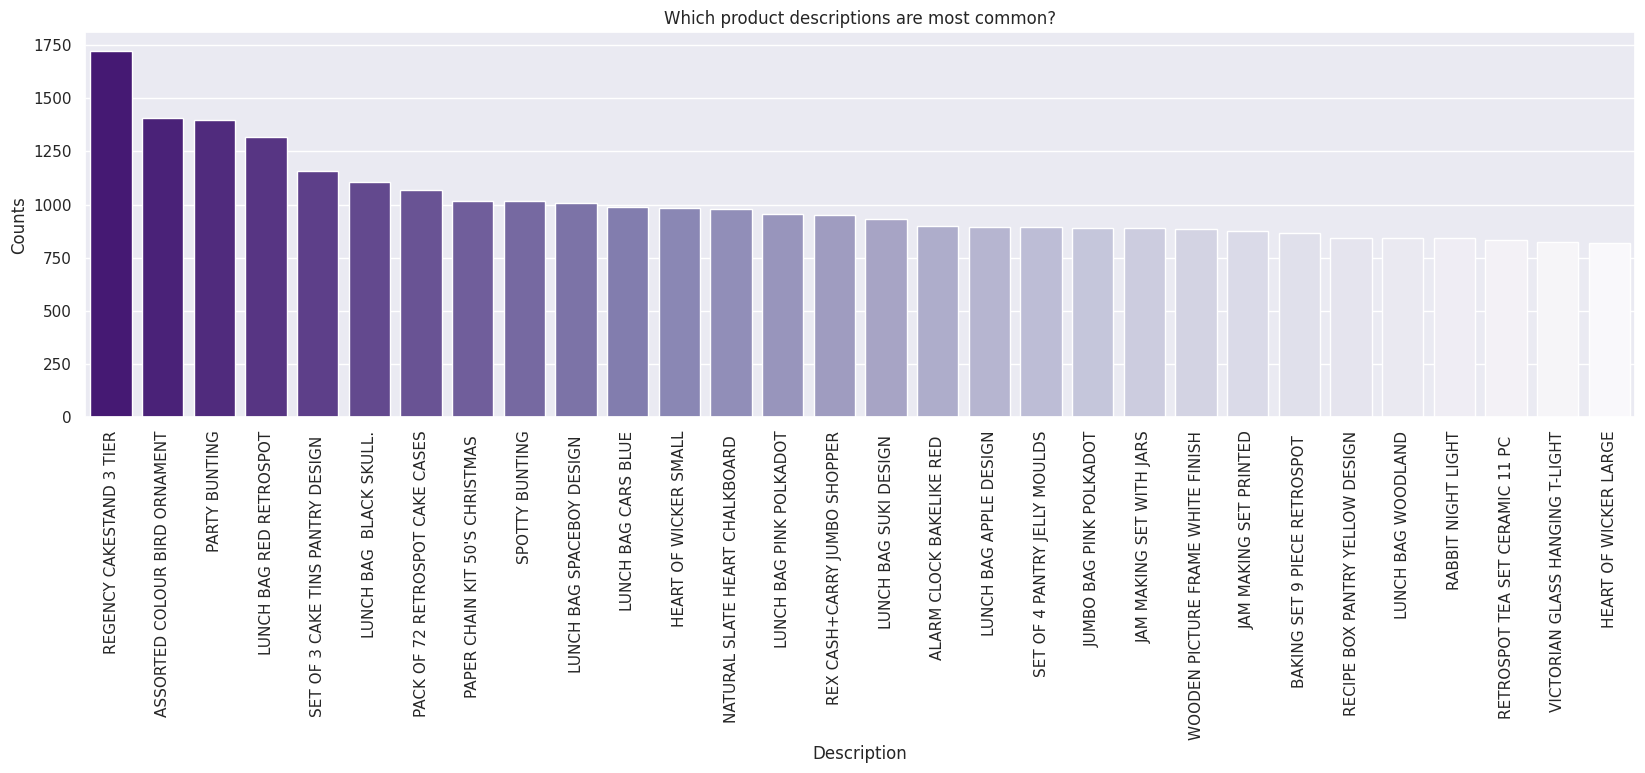

In [152]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]

plt.figure(figsize=(20, 5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?")
plt.xticks(rotation=90)
plt.show()


In [153]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [154]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

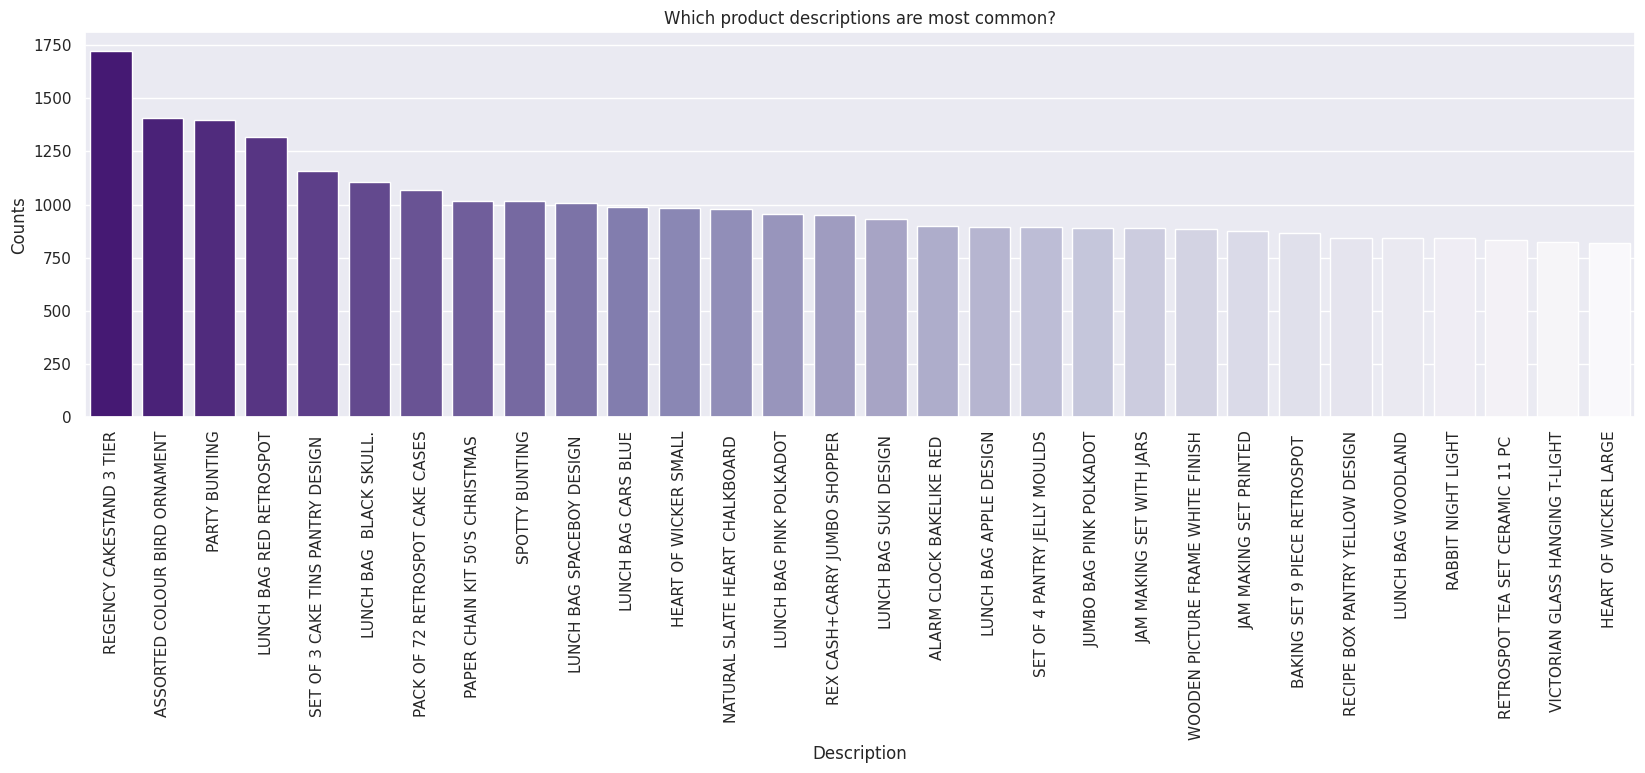

In [155]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]

plt.figure(figsize=(20, 5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?")
plt.xticks(rotation=90)
plt.show()

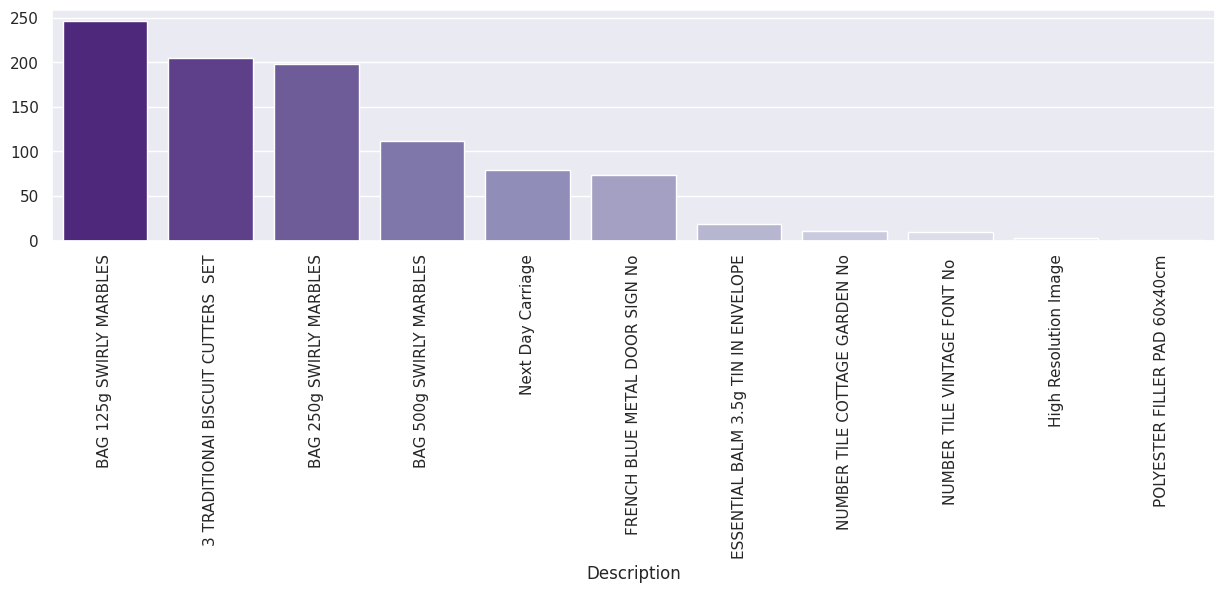

In [156]:
lowchar_counts = data.loc[data.LowCharsInDescription > 0].Description.value_counts()

plt.figure(figsize=(15, 3))
sns.barplot(x=lowchar_counts.index, y=lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90)
plt.show()


In [157]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [158]:
data.UpCharsInDescription.describe()

,UpCharsInDescription
count,362522.000000
mean,22.572291
std,4.354845
min,3.000000
25%,20.000000
50%,23.000000
75%,26.000000
max,32.000000


In [159]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

,count
Description,
Next Day Carriage,79
High Resolution Image,3


In [160]:
data = data.loc[data.UpCharsInDescription > 5].copy()

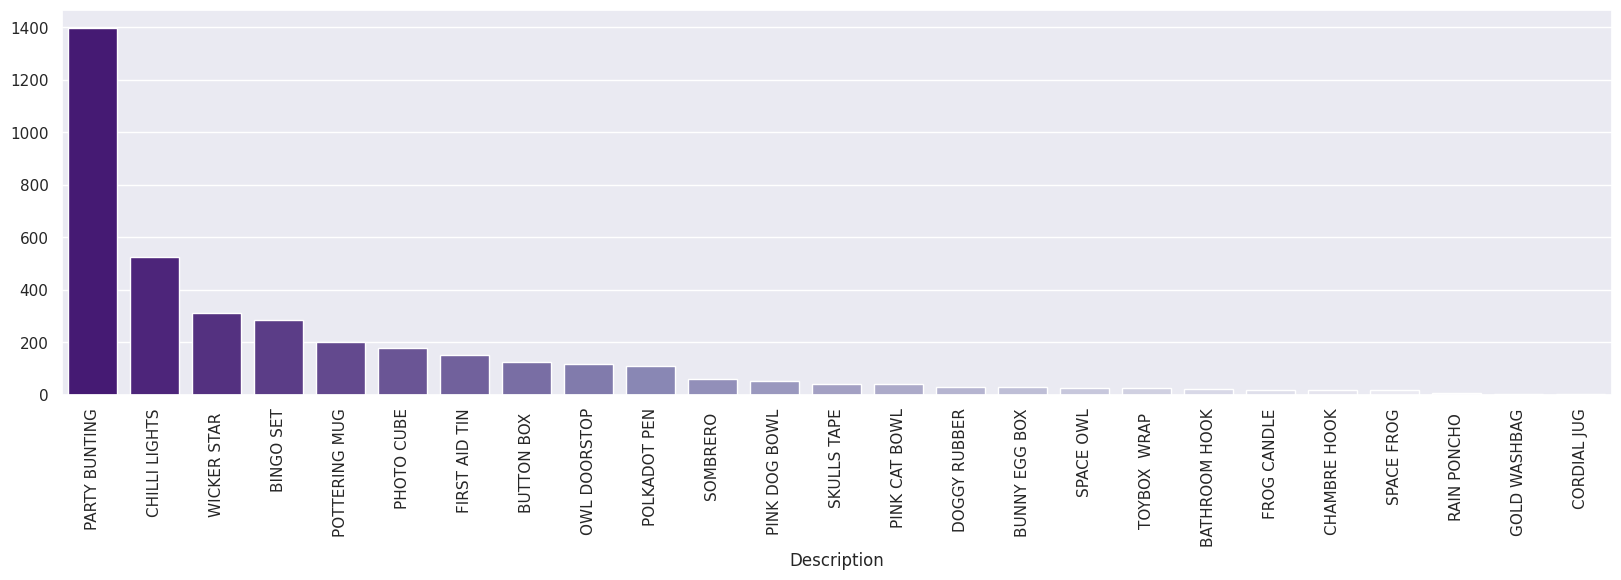

In [161]:
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

plt.figure(figsize=(20, 5))
sns.barplot(x=dlength_counts.index, y=dlength_counts.values, palette="Purples_r")
plt.xticks(rotation=90)
plt.show()


In [162]:
data.StockCode.nunique()

2781

In [163]:
data.Description.nunique()

2981

In [164]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

,Description
StockCode,
23236,4
23196,4
23413,3
23244,3
23126,3
23203,3
23209,3
23366,3
23131,3


In [165]:
data.loc[data.StockCode == "23244"].Description.value_counts()

,count
Description,
ROUND STORAGE TIN VINTAGE LEAF,96
STORAGE TIN VINTAGE LEAF,7
CANNISTER VINTAGE LEAF DESIGN,2


In [166]:
data.CustomerID.nunique()

4315

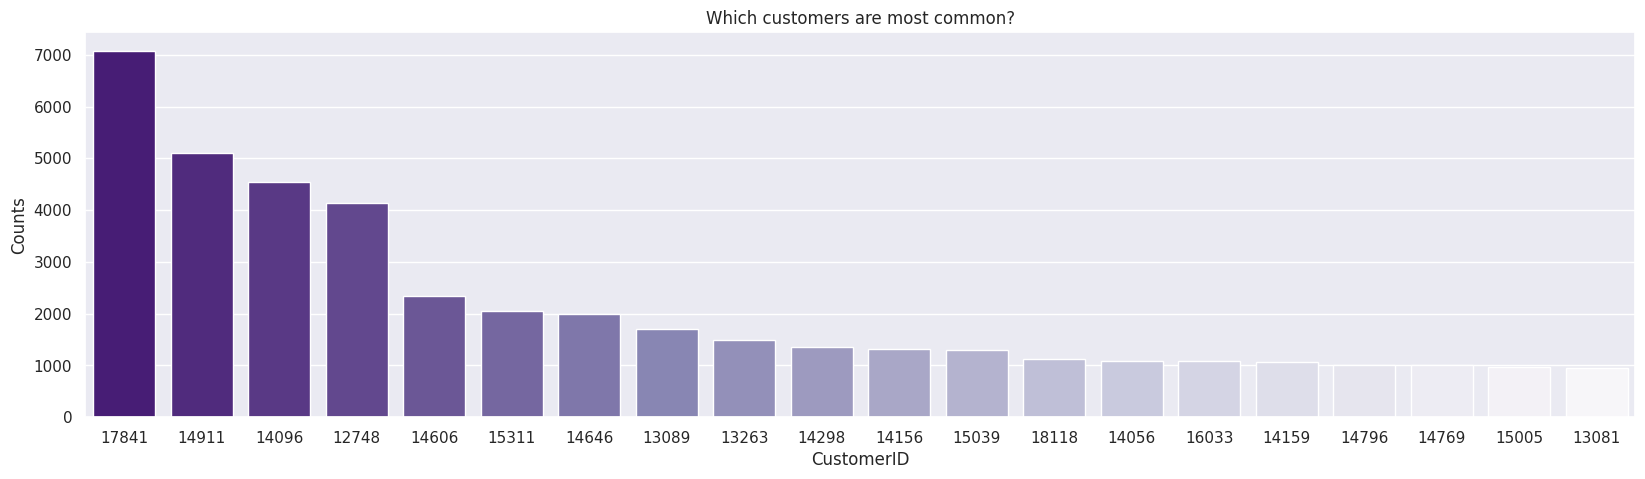

In [167]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20]

plt.figure(figsize=(20, 5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index, palette="Purples_r")
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?")
# Uncomment the line below if the x-axis labels overlap
# plt.xticks(rotation=90)
plt.show()


In [168]:
data.Country.nunique()

37

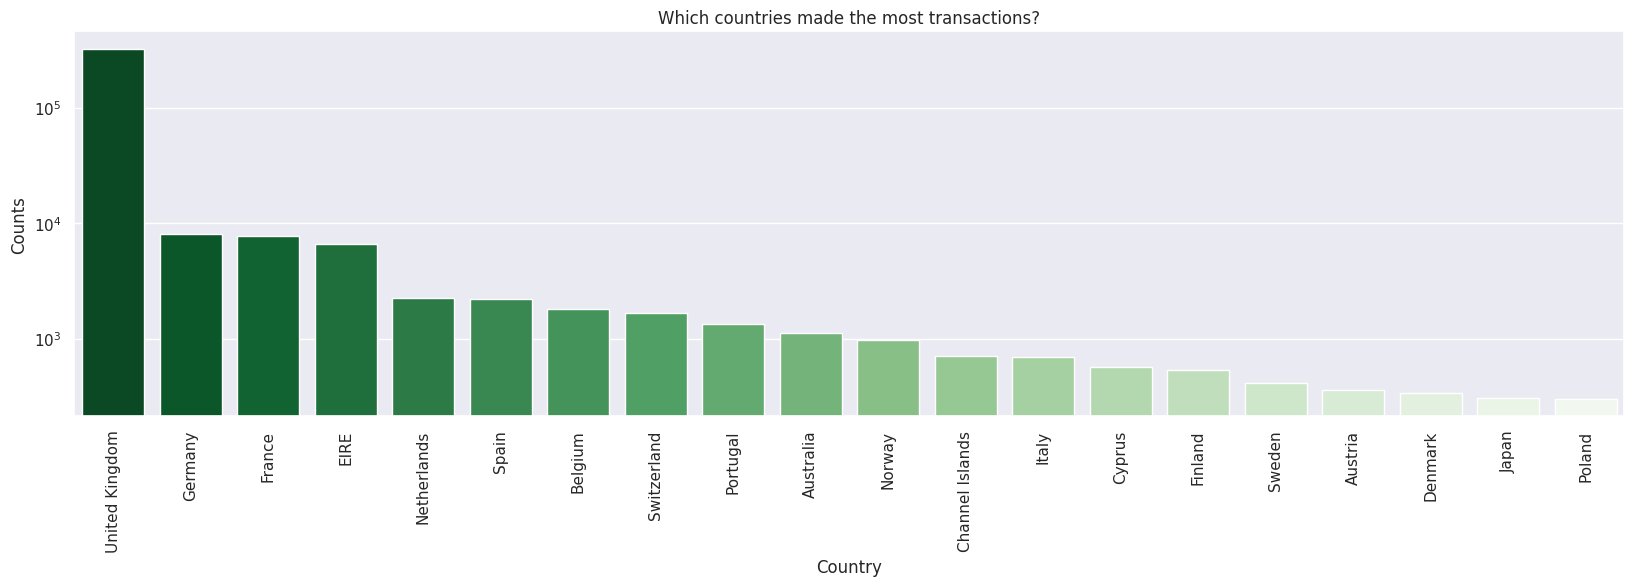

In [169]:
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]

plt.figure(figsize=(20, 5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?")
plt.xticks(rotation=90)
plt.yscale("log")
plt.show()


In [170]:
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.10192031784572

In [171]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

In [172]:
data.UnitPrice.describe()

,UnitPrice
count,362440.000000
mean,2.885355
std,4.361812
min,0.000000
25%,1.250000
50%,1.790000
75%,3.750000
max,649.500000


In [173]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,25,1
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,20,0
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,26,0
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,29,0
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,15,0


In [174]:
data = data.loc[data.UnitPrice > 0].copy()

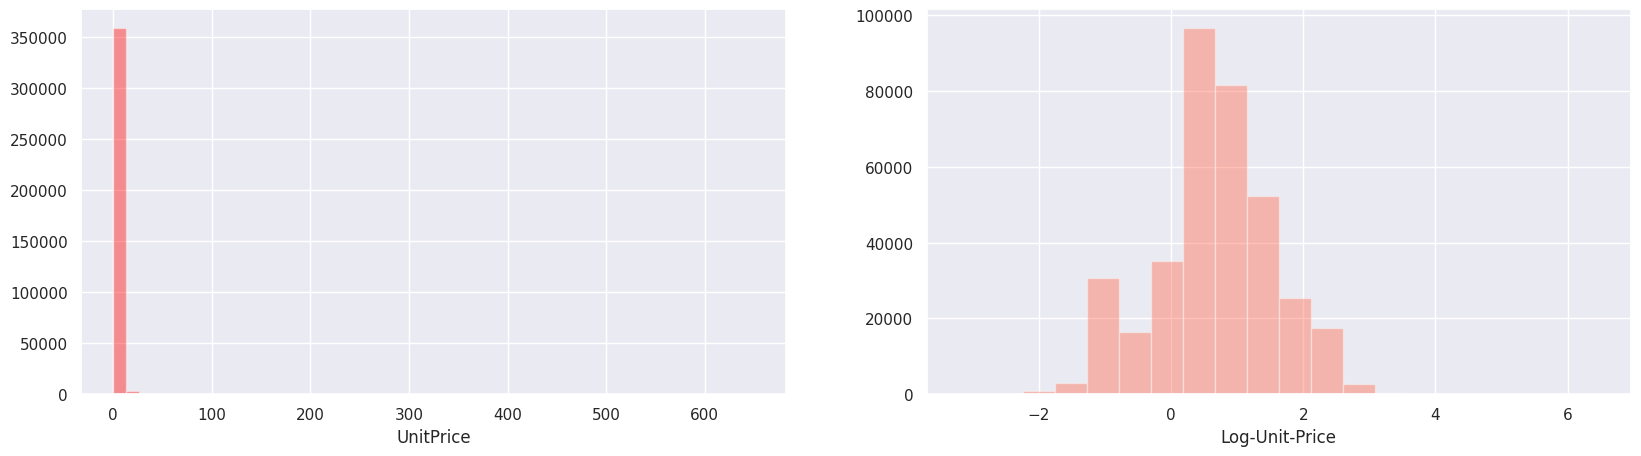

In [175]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.UnitPrice, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.UnitPrice), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [176]:
np.quantile(data.UnitPrice, 0.95)

8.5

In [177]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

In [178]:
data.Quantity.describe()

,Quantity
count,361608.000000
mean,13.024112
std,187.566510
min,1.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,80995.000000


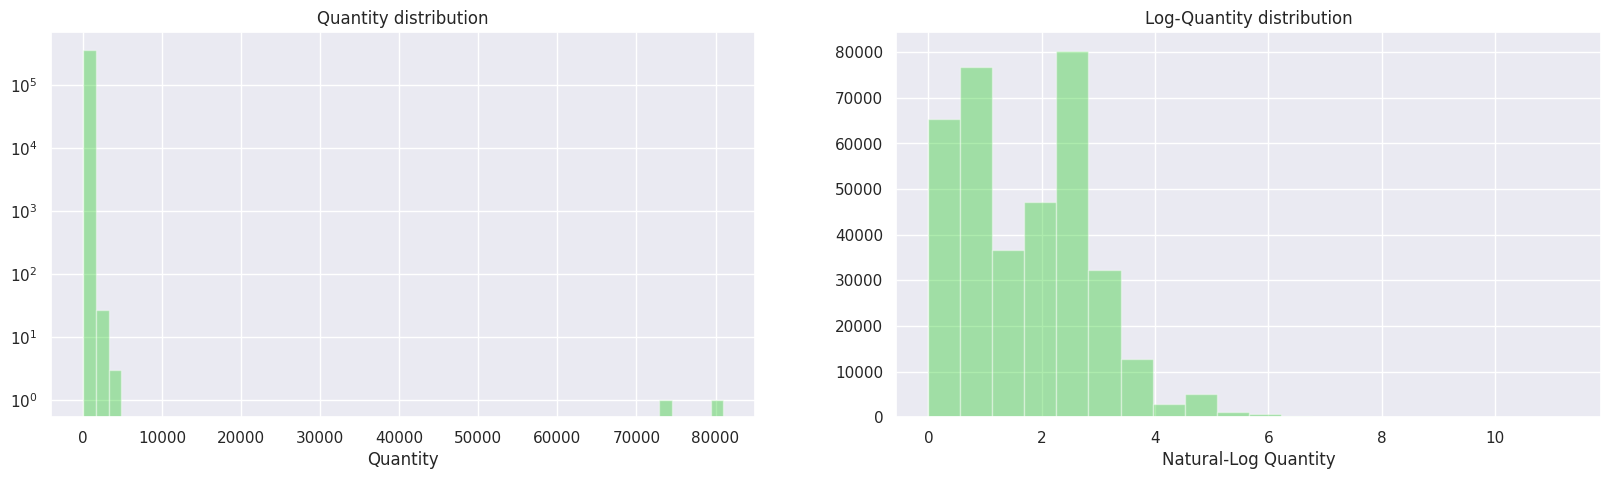

In [179]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

In [180]:
np.quantile(data.Quantity, 0.95)

36.0

In [181]:
data = data.loc[data.Quantity < 55].copy()

In [182]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.isocalendar().week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [183]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [184]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [185]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,195853.000000,195853.000000
mean,14.964244,28.181114
std,18.809496,43.938183
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.600000
max,411.000000,1266.300000


In [186]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.48000000001048)


In [187]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


In [188]:
samples = daily_data.shape[0]

In [189]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [190]:
samples - daily_data.shape[0]

5258

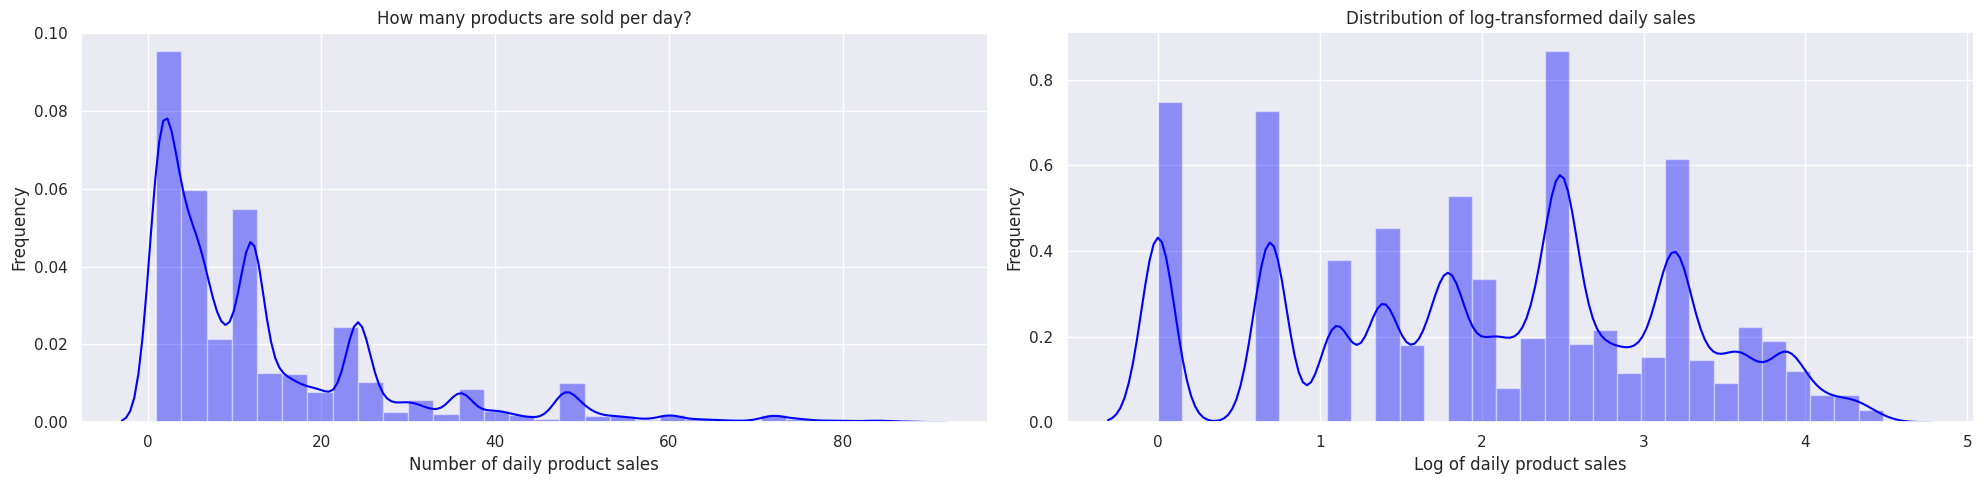

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Blue", bins=30)
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Blue", bins=30)

ax[0].set_xlabel("Number of daily product sales")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many products are sold per day?")
ax[1].set_xlabel("Log of daily product sales")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of log-transformed daily sales")

plt.tight_layout()
plt.show()


In [192]:
class CatHyperparameter:

    def __init__(self,loss="RMSE",metric="RMSE",iterations=1000, max_depth=4,l2_leaf_reg=3,learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

In [193]:
class Catmodel:

    def __init__(self, name, params):
        self.name = name
        self.params = params

    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)

    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )

    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))

    def score(self):
        return self.model.score(self.val_pool)

    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)

    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))

    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax

    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))

    def predict(self, x):
        return self.model.predict(x)

    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )

In [194]:
import GPyOpt

class Hypertuner:

    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None

    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()

    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))

    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

In [195]:
class CatFamily:

    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params

    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)

    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool

    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)

    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score

    def score(self):
        return np.mean(self.model_scores)

    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")

In [196]:
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [197]:
daily_data["Date"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]])

week = daily_data.Week.max() - 2

print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week == week].Date.min()
))


Validation after week 49
Validation starts at timepoint 2010-12-06 00:00:00


In [198]:
import numpy as np
np.float = float

In [199]:
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 67


In [200]:
model.score()

0.21137455943963013

Median absolute error: 0.781937323325981


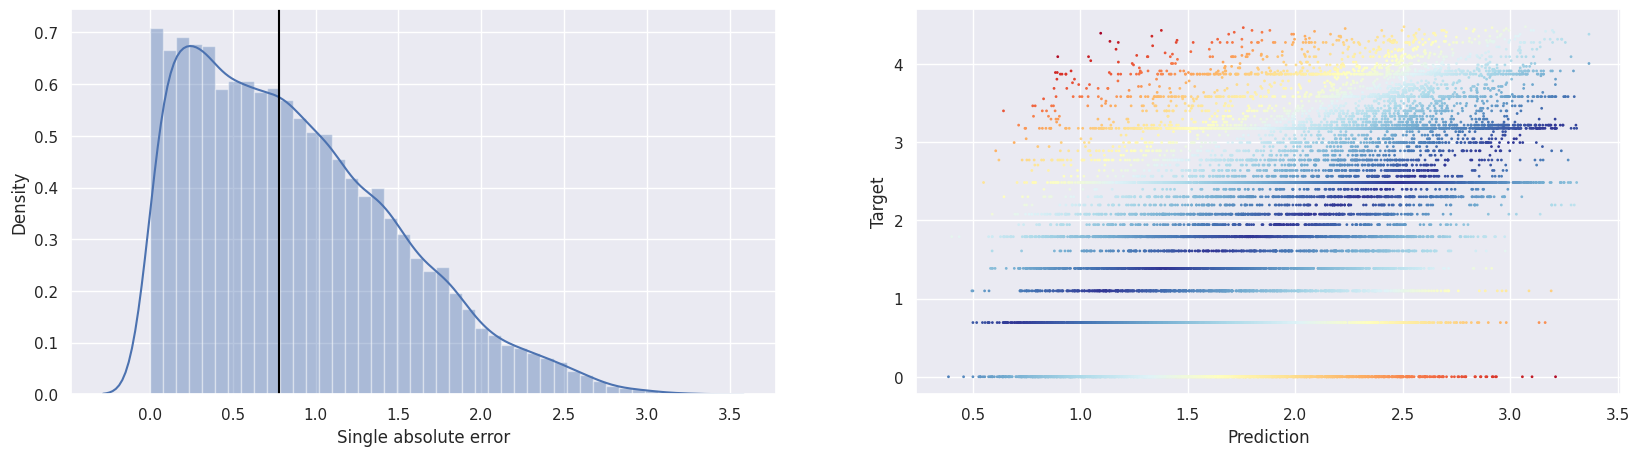

In [201]:
model.show_val_results();

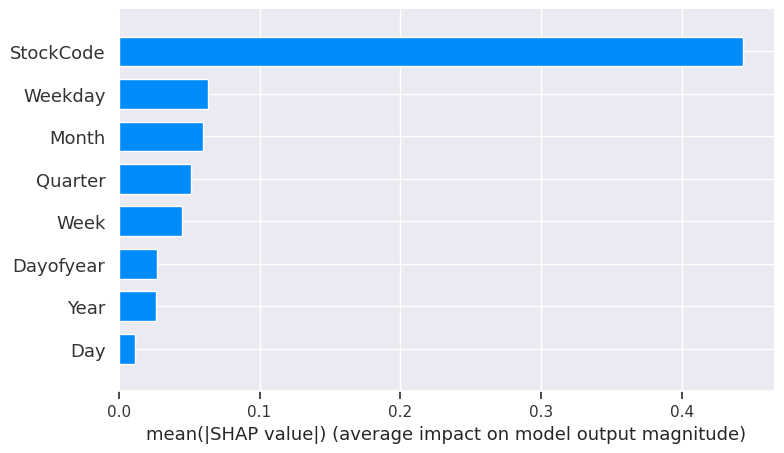

In [202]:
model.show_importances()

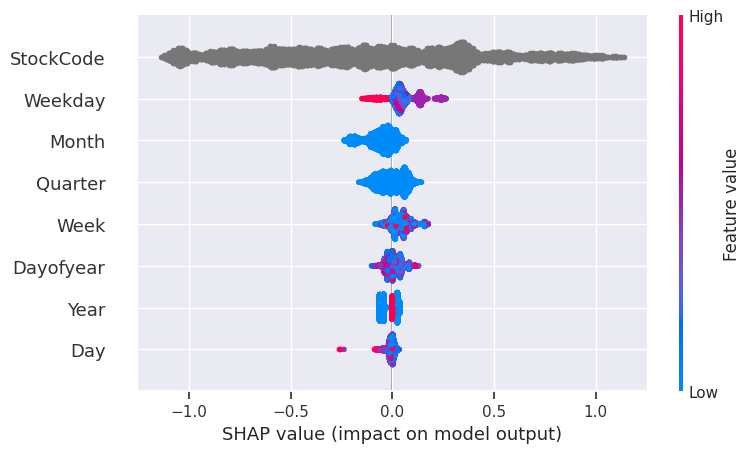

In [203]:
model.show_importances(kind=None)

In [204]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

9.607548705536649

In [205]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

4.805259673034712

baseline, early-stopped model tree count 45
baseline, early-stopped model tree count 45
baseline, early-stopped model tree count 45
baseline, early-stopped model tree count 4
baseline, early-stopped model tree count 27
baseline, early-stopped model tree count 4
baseline, early-stopped model tree count 4


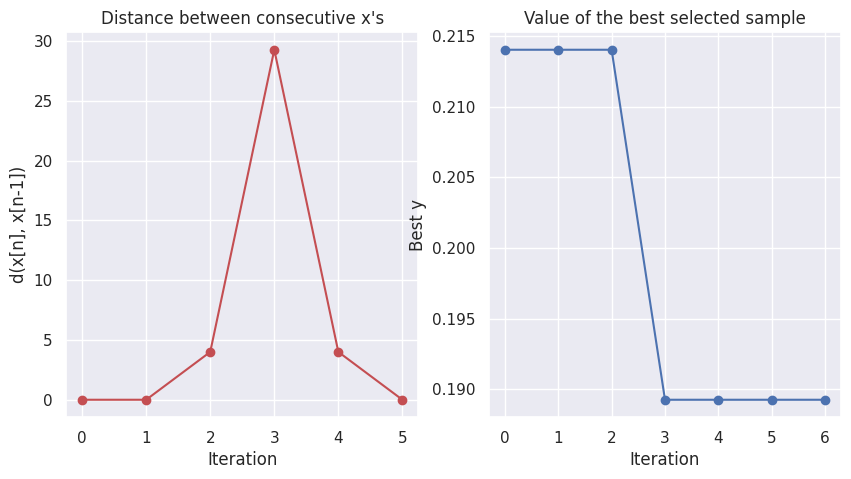

Optimal depth is 1.0 and optimal l2-leaf-reg is 30.0
Optimal RMSE: 0.1892571467270855


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 4
0.1892571467270855


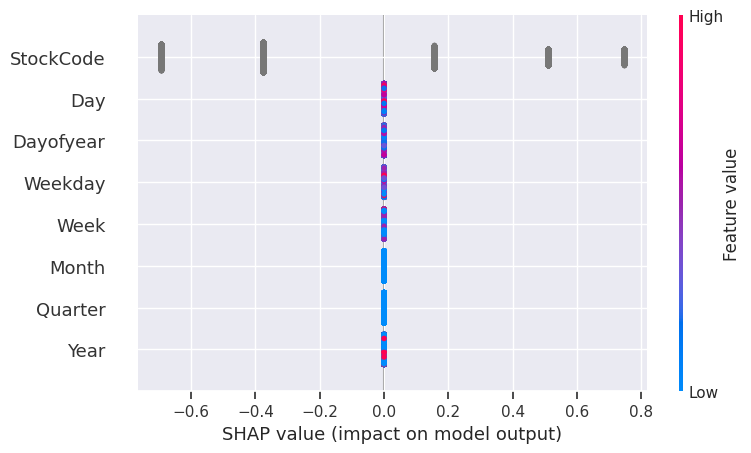

In [206]:
search = Hypertuner(model, max_depth=5, max_l2_leaf_reg=30)
search.learn()
model = search.retrain_catmodel()
print(model.score())
model.show_importances(kind=None)

In [207]:
products = pd.DataFrame(index=data.loc[data.Week < week].StockCode.unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("StockCode").UnitPrice.median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("StockCode").Quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("StockCode").CustomerID.nunique()
products["DescriptionLength"] = data.loc[data.Week < week].groupby("StockCode").DescriptionLength.median()
#products["StockCode"] = products.index.values
org_cols = np.copy(products.columns.values)
products.head()

,MedianPrice,MedianQuantities,Customers,DescriptionLength
71053,3.75,4.0,137,19.0
22752,8.50,2.0,163,28.0
21730,4.95,3.0,64,33.0
22633,2.10,4.0,263,22.0
22632,2.10,4.0,227,25.0


In [208]:
for col in org_cols:
    if col != "StockCode":
        products[col] = boxcox(products[col])[0]

Text(0, 0.5, 'Boxcox-Median-Quantities')

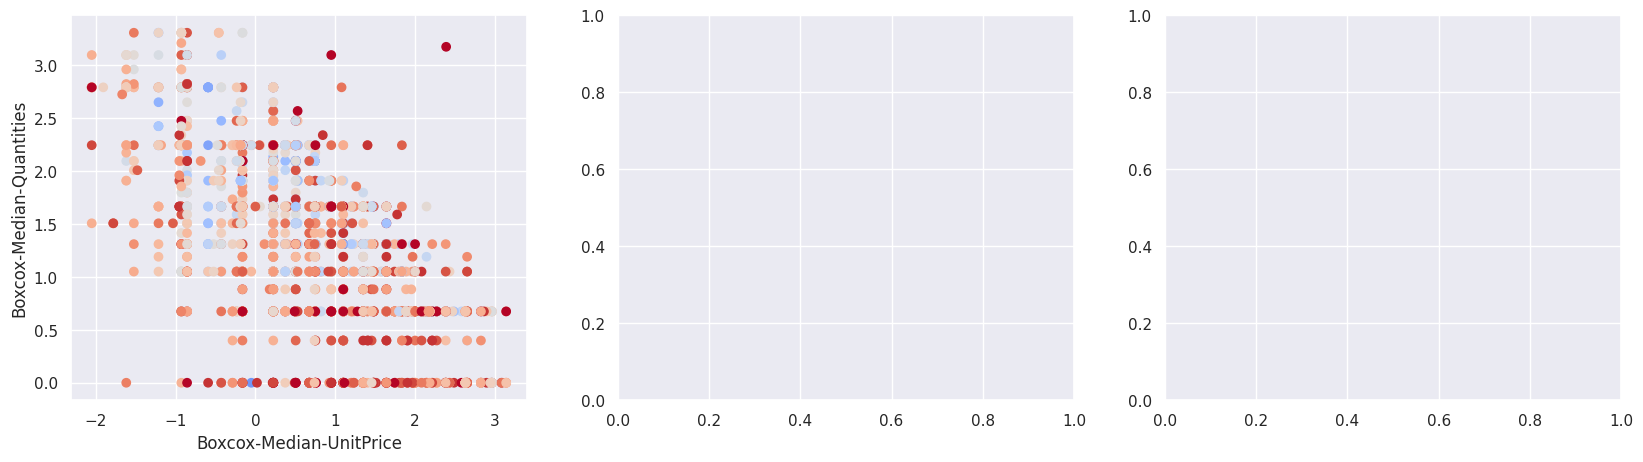

In [209]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [210]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [211]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data.StockCode.map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue,ProductType
0,2010-12-01,2010,4,12,48,2,335,1,10002,4.094345,51.00,17.0
1,2010-12-01,2010,4,12,48,2,335,1,10125,0.693147,1.70,19.0
2,2010-12-01,2010,4,12,48,2,335,1,10133,1.609438,4.25,22.0
3,2010-12-01,2010,4,12,48,2,335,1,16014,2.302585,4.20,17.0
4,2010-12-01,2010,4,12,48,2,335,1,16016,2.302585,8.50,17.0


In [212]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data.StockCode.map(
    data.groupby("StockCode").UnitPrice.median())

known_price_iqr = data.groupby("StockCode").UnitPrice.quantile(0.75)
known_price_iqr -= data.groupby("StockCode").UnitPrice.quantile(0.25)
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data.StockCode.map(known_price_iqr)

In [213]:
to_group = ["StockCode", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [214]:
daily_data.head()

,StockCode,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,Quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,4.094345,51.00,17.0,0.85,0.0000,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.693147,1.70,19.0,0.85,0.0000,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,1.609438,4.25,22.0,0.42,0.3225,0.85,0.85,NaN
3,16014,2010,12,48,2,2010-12-01,4,335,1,2.302585,4.20,17.0,0.42,0.0000,0.42,0.42,NaN
4,16016,2010,12,48,2,2010-12-01,4,335,1,2.302585,8.50,17.0,0.85,0.0000,0.85,0.85,NaN


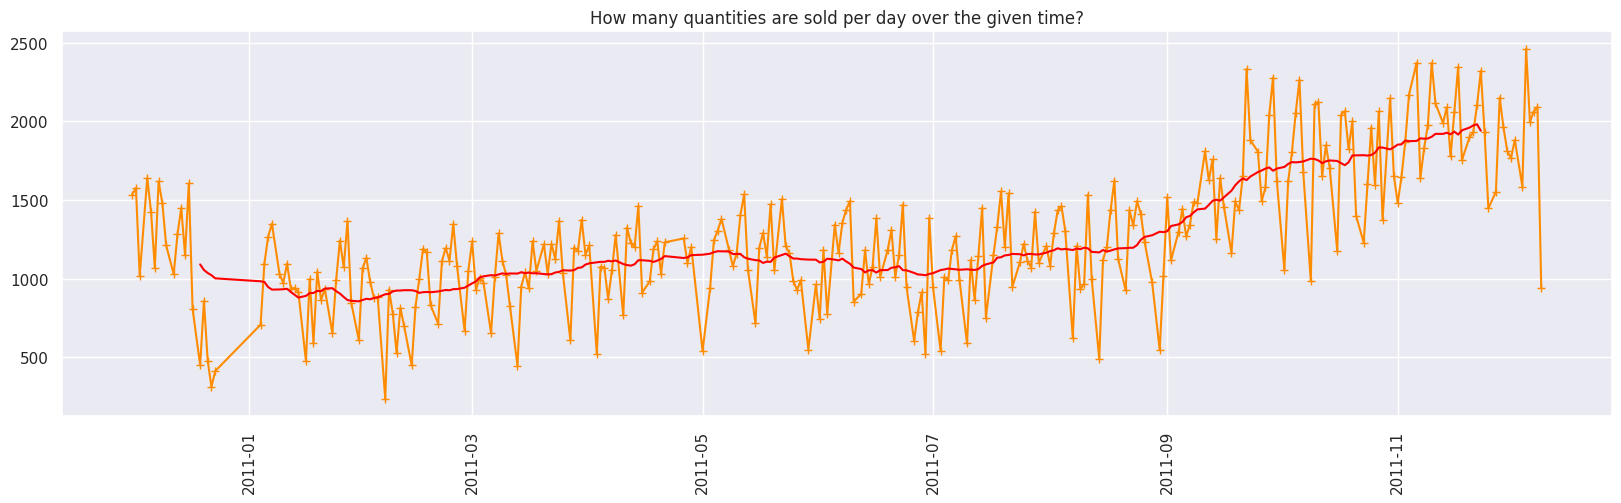

In [215]:
plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

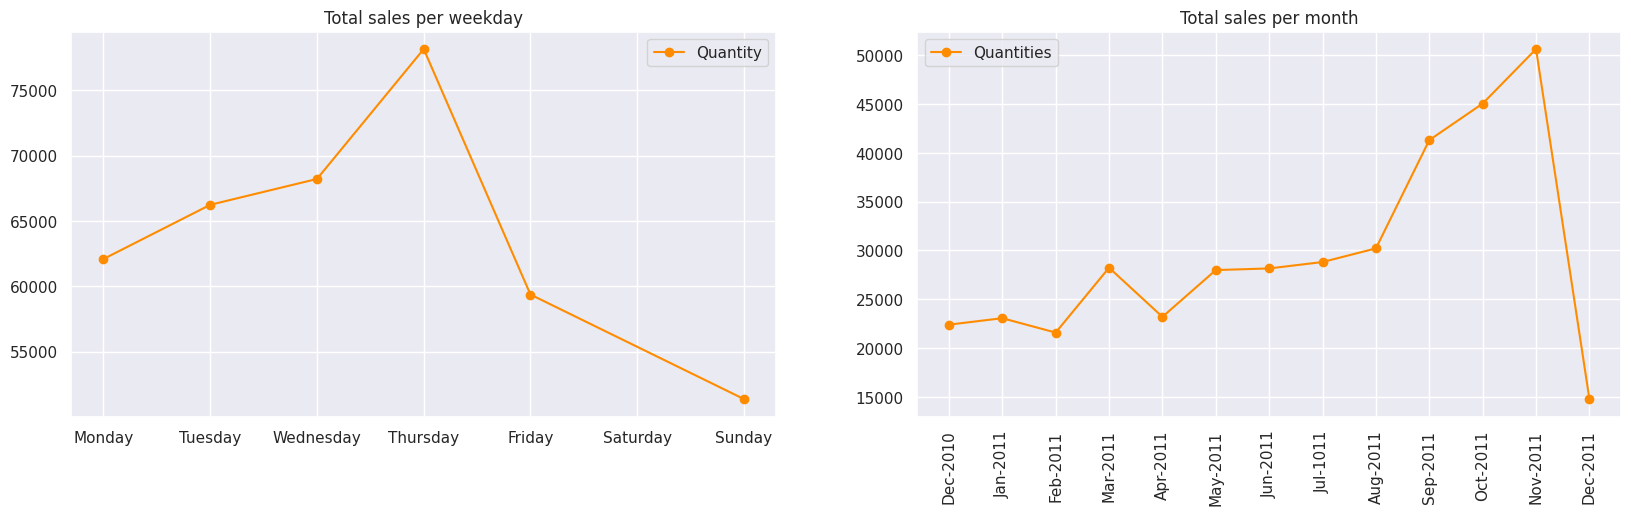

In [216]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011",
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

In [217]:
daily_data["PreChristmas"] = (daily_data.Dayofyear <= 358) & (daily_data.Dayofyear >= 243)

In [218]:
for col in ["Weekday", "Month", "Quarter"]:
    daily_data = daily_data.set_index(col)
    daily_data[col+"Quantity_mean"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.mean()
    daily_data[col+"Quantity_median"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.median()
    daily_data[col+"Quantity_mean_median_diff"] = daily_data[col+"Quantity_mean"] - daily_data[col+"Quantity_median"]
    daily_data[col+"Quantity_IQR"] = daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.75) - daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.25)
    daily_data = daily_data.reset_index()
daily_data.head()

,Quarter,Month,Weekday,StockCode,Year,Week,Date,Dayofyear,Day,Quantity,...,WeekdayQuantity_mean_median_diff,WeekdayQuantity_IQR,MonthQuantity_mean,MonthQuantity_median,MonthQuantity_mean_median_diff,MonthQuantity_IQR,QuarterQuantity_mean,QuarterQuantity_median,QuarterQuantity_mean_median_diff,QuarterQuantity_IQR
0,4,12,2,10002,2010,48,2010-12-01,335,1,4.094345,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
1,4,12,2,10125,2010,48,2010-12-01,335,1,0.693147,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
2,4,12,2,10133,2010,48,2010-12-01,335,1,1.609438,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
3,4,12,2,16014,2010,48,2010-12-01,335,1,2.302585,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
4,4,12,2,16016,2010,48,2010-12-01,335,1,2.302585,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712


In [219]:
to_group = ["StockCode", "PreChristmas"]
daily_data = daily_data.set_index(to_group)
daily_data["PreChristmasMeanQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.mean().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasMedianQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.median().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasStdQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.std().apply(lambda l: np.round(l, 1))
daily_data = daily_data.reset_index()

In [220]:
for delta in range(1,4):
    to_group = ["Week","Weekday","ProductType"]
    daily_data = daily_data.set_index(to_group)

    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)

    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan


In [221]:
data["ProductType"] = data.StockCode.map(products.cluster)

In [222]:
daily_data["TransactionsPerProductType"] = daily_data.ProductType.map(data.loc[data.Week < week].groupby("ProductType").InvoiceNo.nunique())

In [223]:
delta = 1
to_group = ["Week", "Weekday", "ProductType"]
daily_data = daily_data.set_index(to_group)
daily_data["DummyWeekWeekdayAttraction"] = data.groupby(to_group).CustomerID.nunique()
daily_data["DummyWeekWeekdayMeanUnitPrice"] = data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2))

daily_data["WeekWeekdayAttraction_Lag1"] = daily_data["DummyWeekWeekdayAttraction"].shift(1)
daily_data["WeekWeekdayMeanUnitPrice_Lag1"] = daily_data["DummyWeekWeekdayMeanUnitPrice"].shift(1)

daily_data = daily_data.reset_index()
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayAttraction_Lag1"] = np.nan
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayMeanUnitPrice_Lag1"] = np.nan
daily_data = daily_data.drop(["DummyWeekWeekdayAttraction", "DummyWeekWeekdayMeanUnitPrice"], axis=1)

In [224]:
daily_data["TransactionsPerStockCode"] = daily_data.StockCode.map(
    data.loc[data.Week < week].groupby("StockCode").InvoiceNo.nunique())

In [225]:
daily_data.head()

,Week,Weekday,ProductType,StockCode,PreChristmas,Quarter,Month,Year,Date,Dayofyear,...,QuantityProducttypeWeekWeekdayLag_1_median,QuantityProductTypeWeekWeekdayLag_1_median,QuantityProducttypeWeekWeekdayLag_2_median,QuantityProductTypeWeekWeekdayLag_2_median,QuantityProducttypeWeekWeekdayLag_3_median,QuantityProductTypeWeekWeekdayLag_3_median,TransactionsPerProductType,WeekWeekdayAttraction_Lag1,WeekWeekdayMeanUnitPrice_Lag1,TransactionsPerStockCode
0,48,2,17.0,10002,True,4,12,2010,2010-12-01,335,...,1.1,NaN,1.8,NaN,0.7,NaN,3848.0,NaN,NaN,33.0
1,48,2,19.0,10125,True,4,12,2010,2010-12-01,335,...,2.5,NaN,2.5,NaN,1.1,NaN,2347.0,48.0,1.06,50.0
2,48,2,22.0,10133,True,4,12,2010,2010-12-01,335,...,1.8,NaN,0.7,NaN,2.5,NaN,3304.0,21.0,1.24,107.0
3,48,2,17.0,16014,True,4,12,2010,2010-12-01,335,...,1.1,NaN,1.8,NaN,0.7,NaN,3848.0,29.0,0.41,38.0
4,48,2,17.0,16016,True,4,12,2010,2010-12-01,335,...,1.1,NaN,1.8,NaN,0.7,NaN,3848.0,48.0,1.06,53.0


In [226]:
daily_data["CustomersPerWeekday"] = daily_data.Month.map(
    data.loc[data.Week < week].groupby("Weekday").CustomerID.nunique())

In [227]:
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("new_features_1", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 26


In [228]:
model.score()

0.46093035475391175

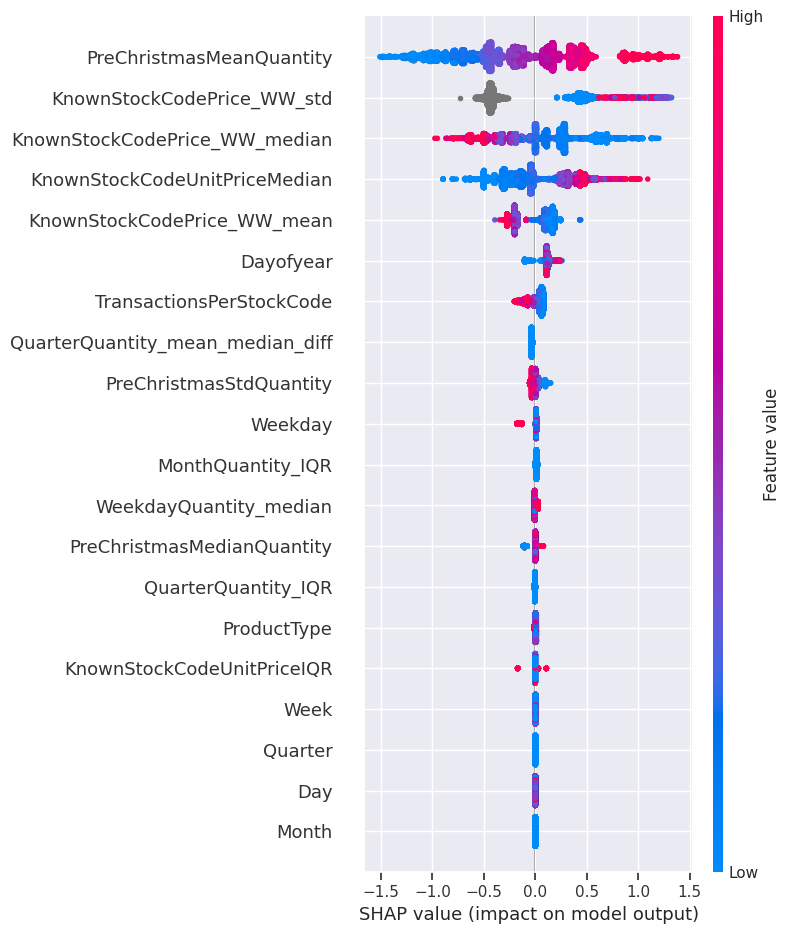

In [229]:
model.show_importances(kind=None)

Median absolute error: 0.5869893858877009


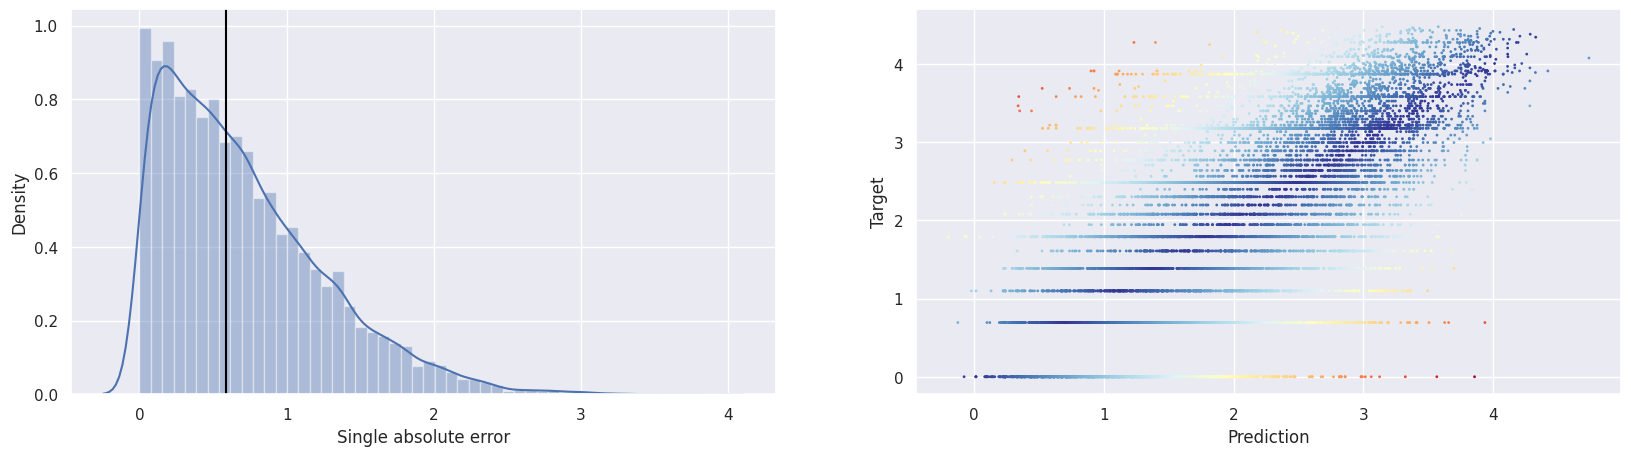

In [230]:
model.show_val_results();

In [231]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

7.663954191398777

In [232]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

4.098885700121031

new_features_1, early-stopped model tree count 106
new_features_1, early-stopped model tree count 106
new_features_1, early-stopped model tree count 106
new_features_1, early-stopped model tree count 515
new_features_1, early-stopped model tree count 34
new_features_1, early-stopped model tree count 511


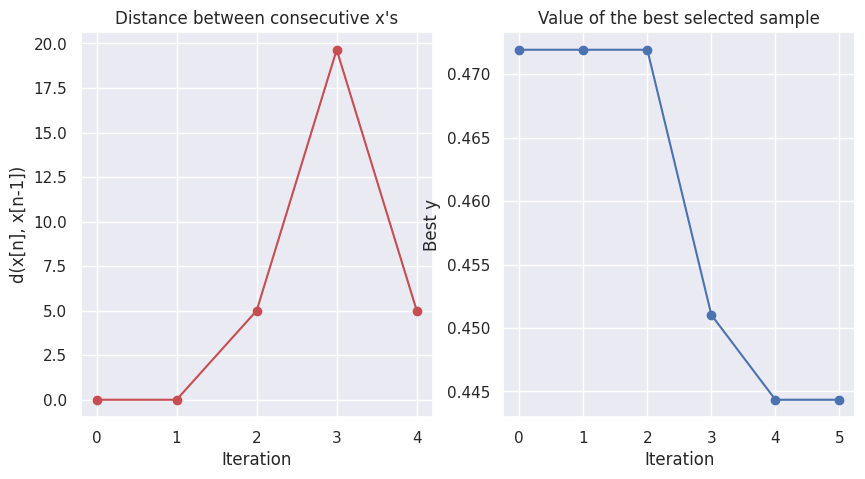

Optimal depth is 6.0 and optimal l2-leaf-reg is 1.0
Optimal RMSE: 0.4443460522038104


In [233]:
search = Hypertuner(model)
search.learn()

In [234]:
model = search.retrain_catmodel()
print(model.score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 34
0.4443460522038104


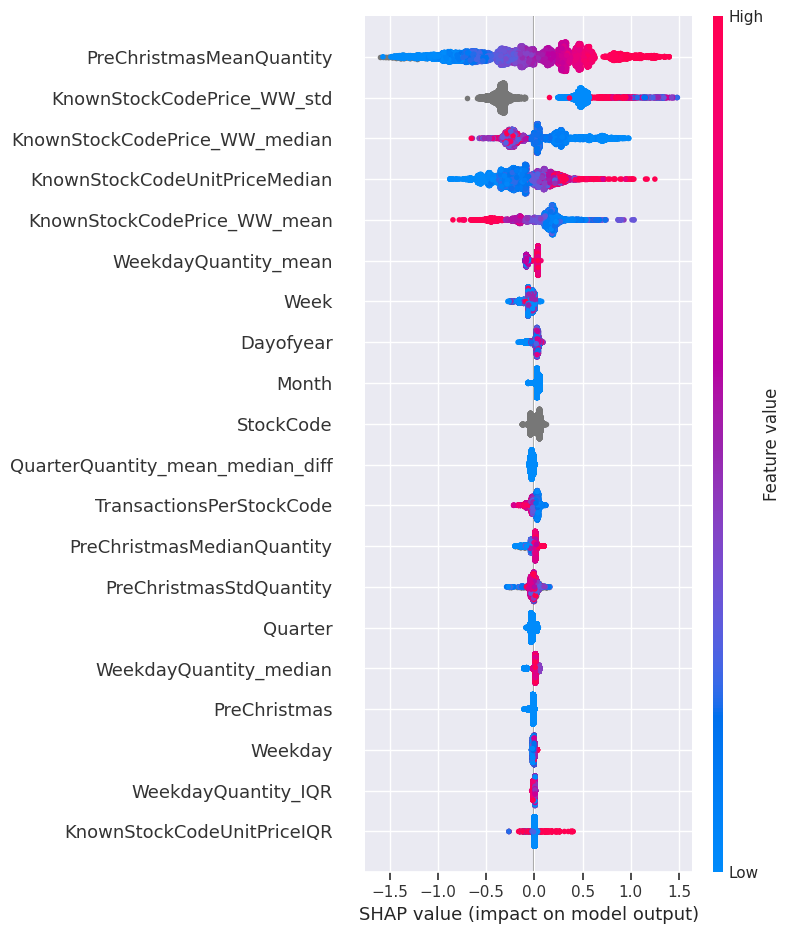

In [235]:
model.show_importances(kind=None)